# MRI Brain Tumour Classifier, based on Google's EfficientNetB3 Model
References:
- https://keras.io/api/applications/efficientnet/
- https://paperswithcode.com/method/efficientnet
- https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
- https://arxiv.org/abs/1905.11946
- https://www.kaggle.com/code/surbhiwalecha/brain-tumor-prediction-efficientnet-me-satrajit

In [1]:
# Import required functions and libraries
from utils import *
from sklearn.model_selection import StratifiedKFold, KFold
import json

# Dataset Preparations

Found 480 files belonging to 4 classes.
Using 384 files for training.
Using 96 files for validation.

Training Dataset Preview


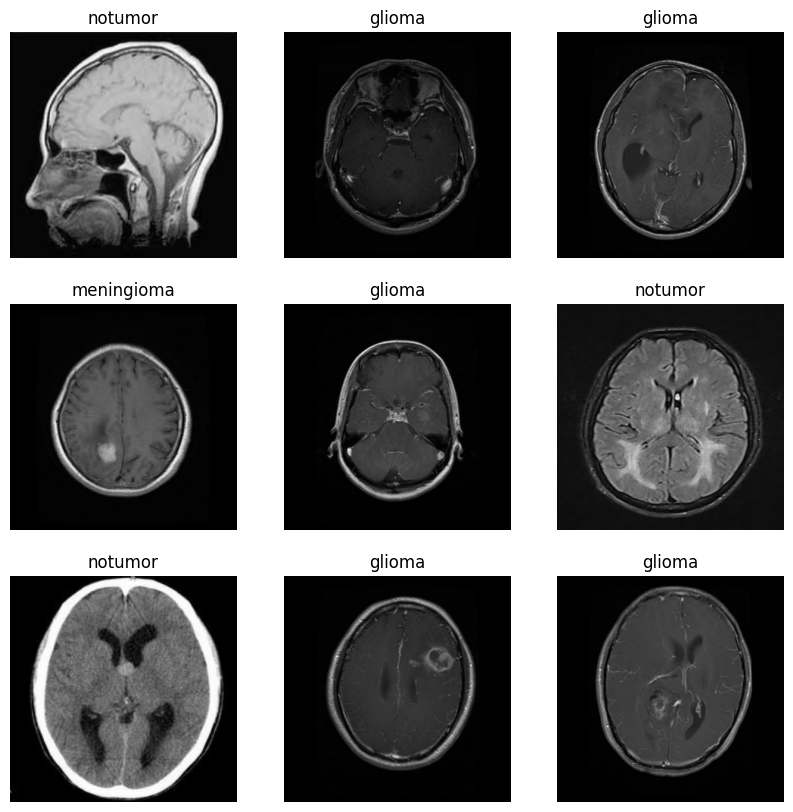

Validation Dataset Preview


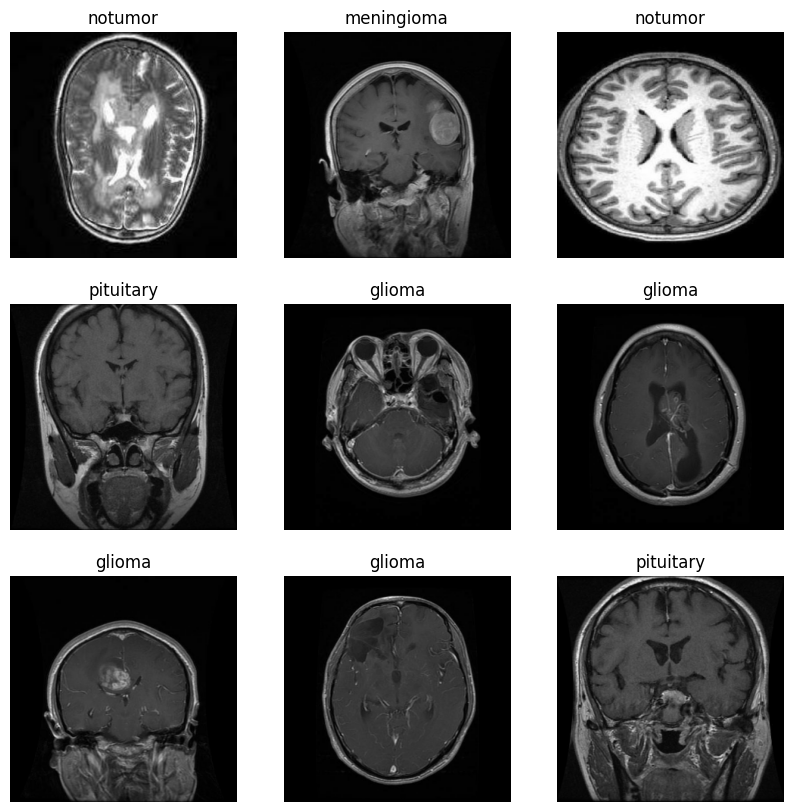

In [2]:
# Parameters
img_batch_size = 32
img_height = 300
img_width = 300
img_size = (img_height, img_width) # EfficientNetB3 requires 300x300 input images
img_shape = img_size + (3,)

# Get training and validation datasets
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
  DATASET_FOLDER,
  validation_split=0.2,
  subset="both",
  shuffle=True,
  seed=RANDOM_STATE,
  image_size=img_size,
  batch_size=img_batch_size)

# Get class names
class_names = train_ds.class_names
# class_names = val_ds.class_names

# Enable buffered prefetching to overlap data preprocessing and model execution during training, to speed up access to dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Preview datasets
print("\nTraining Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

print("Validation Dataset Preview")
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

## Build the base model
Create a base model, by attaching a new classification head on top of the EfficientNetB3 model for transfer learning.

In [3]:
# Load the EfficientNetB3 model pretrained on ImageNet without the top layers
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights="imagenet", input_shape=img_shape, pooling='max')

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.016),
                            activity_regularizer=tf.keras.regularizers.l1(0.006),
                            bias_regularizer=tf.keras.regularizers.l1(0.006), activation= 'relu'),
    tf.keras.layers.Dropout(rate=0.45),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(tf.keras.optimizers.Adamax(learning_rate= 0.001), loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

In [14]:
# Load the EfficientNetB3 model pretrained on ImageNet without the top layers
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights="imagenet", input_shape=img_shape)
model_2 = base_model.output
model_2 = tf.keras.layers.GlobalAveragePooling2D()(model_2)
model_2 = tf.keras.layers.Dropout(0.5)(model_2)
model_2 = tf.keras.layers.Dense(len(class_names), activation='softmax')(model_2)
model_2 = tf.keras.models.Model(inputs = base_model.input , outputs = model_2)

# Compile the model
model_2.compile(tf.keras.optimizers.Adamax(learning_rate= 0.001), loss='sparse_categorical_crossentropy', metrics= ['accuracy'])
model_2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 rescaling_4 (Rescaling)     (None, 300, 300, 3)          0         ['input_3[0][0]']             
                                                                                                  
 normalization_2 (Normaliza  (None, 300, 300, 3)          7         ['rescaling_4[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 300, 300, 3)          0         ['normalization_2[0][0]'] 

## Model Training

In [4]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=64)

Epoch 1/30
12/12 [==============================] - 75s 1s/step - loss: 8.7730 - accuracy: 0.6536 - val_loss: 15.6089 - val_accuracy: 0.4271
Epoch 2/30
12/12 [==============================] - 13s 1s/step - loss: 7.7637 - accuracy: 0.8542 - val_loss: 12.7041 - val_accuracy: 0.5312
Epoch 3/30
12/12 [==============================] - 13s 1s/step - loss: 7.3230 - accuracy: 0.9323 - val_loss: 10.9047 - val_accuracy: 0.6146
Epoch 4/30
12/12 [==============================] - 13s 1s/step - loss: 6.8773 - accuracy: 0.9714 - val_loss: 9.5775 - val_accuracy: 0.6042
Epoch 5/30
12/12 [==============================] - 13s 1s/step - loss: 6.5836 - accuracy: 0.9583 - val_loss: 8.3124 - val_accuracy: 0.6979
Epoch 6/30
12/12 [==============================] - 13s 1s/step - loss: 6.2201 - accuracy: 0.9818 - val_loss: 7.4379 - val_accuracy: 0.6562
Epoch 7/30
12/12 [==============================] - 13s 1s/step - loss: 5.9449 - accuracy: 0.9844 - val_loss: 6.6219 - val_accuracy: 0.7812
Epoch 8/30
12/12 

In [15]:
history_2 = model_2.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=64)

Epoch 1/30
12/12 [==============================] - 66s 1s/step - loss: 0.6664 - accuracy: 0.7266 - val_loss: 0.9677 - val_accuracy: 0.6458
Epoch 2/30
12/12 [==============================] - 13s 1s/step - loss: 0.1861 - accuracy: 0.9323 - val_loss: 0.8560 - val_accuracy: 0.7188
Epoch 3/30
12/12 [==============================] - 13s 1s/step - loss: 0.0521 - accuracy: 0.9844 - val_loss: 0.5197 - val_accuracy: 0.8333
Epoch 4/30
12/12 [==============================] - 13s 1s/step - loss: 0.0229 - accuracy: 0.9948 - val_loss: 0.6154 - val_accuracy: 0.8021
Epoch 5/30
12/12 [==============================] - 13s 1s/step - loss: 0.0189 - accuracy: 0.9948 - val_loss: 0.3504 - val_accuracy: 0.8854
Epoch 6/30
12/12 [==============================] - 14s 1s/step - loss: 0.0209 - accuracy: 0.9922 - val_loss: 0.3923 - val_accuracy: 0.8646
Epoch 7/30
12/12 [==============================] - 14s 1s/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.3944 - val_accuracy: 0.8542
Epoch 8/30
12/12 [==

## Visualise Training

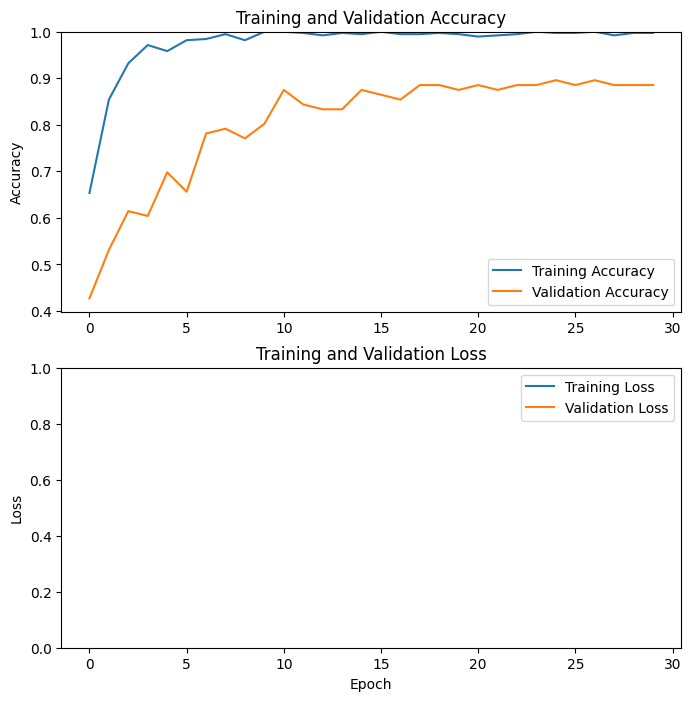

Training Results:
~Accuracy~
Max (best) accuracy: 1.0 at epoch 10
Min (worst) accuracy: 0.6536458134651184 at epoch 1
Median accuracy: 0.9947916865348816
Mean accuracy: 0.9744791646798452

~Loss~
Min (best) loss: 2.317878484725952 at epoch 30
Max (worst) loss: 8.772976875305176 at epoch 1
Median loss: 4.0891242027282715
Mean loss: 4.490388385454813

~Final Training Performance~
Accuracy: 0.96875, Loss: 2.3613929748535156

Validation Results:
~Accuracy~
Max (best) accuracy: 0.8958333134651184 at epoch 25
Min (worst) accuracy: 0.4270833432674408 at epoch 1
Median accuracy: 0.8697916567325592
Mean accuracy: 0.8055555591980617

~Loss~
Min (best) loss: 2.582796335220337 at epoch 30
Max (worst) loss: 15.608924865722656 at epoch 1
Median loss: 4.42055606842041
Mean loss: 5.466344261169434

~Final Validation Performance~
Accuracy: 0.8854166865348816, Loss: 2.582796335220337


In [5]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['accuracy']), "at epoch", history.history['accuracy'].index(max(history.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['accuracy']), "at epoch", history.history['accuracy'].index(min(history.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['accuracy']))
print("Mean accuracy:", np.mean(history.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['loss']), "at epoch", history.history['loss'].index(min(history.history['loss'])) + 1)
print("Max (worst) loss:", max(history.history['loss']), "at epoch", history.history['loss'].index(max(history.history['loss'])) + 1)
print("Median loss:", np.median(history.history['loss']))
print("Mean loss:", np.mean(history.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history.history['val_accuracy']), "at epoch", history.history['val_accuracy'].index(min(history.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history.history['val_accuracy']))
print("Mean accuracy:", np.mean(history.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history.history['val_loss']), "at epoch", history.history['val_loss'].index(min(history.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history.history['val_loss']), "at epoch", history.history['val_loss'].index(max(history.history['val_loss'])) + 1)
print("Median loss:", np.median(history.history['val_loss']))
print("Mean loss:", np.mean(history.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model.evaluate(val_ds, verbose=0)))

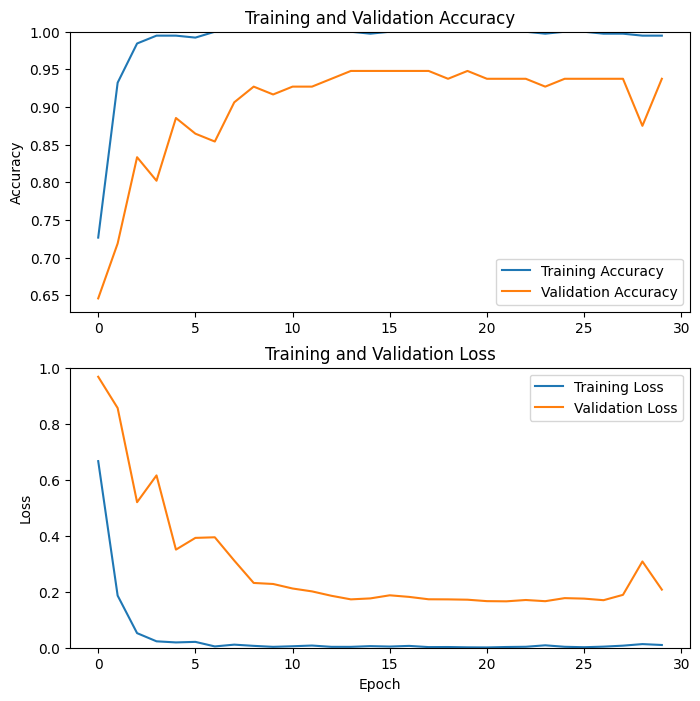

Training Results:
~Accuracy~
Max (best) accuracy: 1.0 at epoch 7
Min (worst) accuracy: 0.7265625 at epoch 1
Median accuracy: 1.0
Mean accuracy: 0.9868055562178294

~Loss~
Min (best) loss: 0.0010270964121446013 at epoch 21
Max (worst) loss: 0.6664224863052368 at epoch 1
Median loss: 0.005480186315253377
Mean loss: 0.03631138508208096

~Final Training Performance~
Accuracy: 1.0, Loss: 0.0049217380583286285

Validation Results:
~Accuracy~
Max (best) accuracy: 0.9479166865348816 at epoch 14
Min (worst) accuracy: 0.6458333134651184 at epoch 1
Median accuracy: 0.9375
Mean accuracy: 0.9024305562178294

~Loss~
Min (best) loss: 0.16568750143051147 at epoch 22
Max (worst) loss: 0.9677266478538513 at epoch 1
Median loss: 0.18802297115325928
Mean loss: 0.286476435760657

~Final Validation Performance~
Accuracy: 0.9375, Loss: 0.20756471157073975


In [22]:
# Visualise model performance throughout epochs
# Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
# Loss
plt.subplot(2, 1, 2)
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()

# Get epoch of optimal parameters
print("Training Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history_2.history['accuracy']), "at epoch", history_2.history['accuracy'].index(max(history_2.history['accuracy'])) + 1)
print("Min (worst) accuracy:", min(history_2.history['accuracy']), "at epoch", history_2.history['accuracy'].index(min(history_2.history['accuracy'])) + 1)
print("Median accuracy:", np.median(history_2.history['accuracy']))
print("Mean accuracy:", np.mean(history_2.history['accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history_2.history['loss']), "at epoch", history_2.history['loss'].index(min(history_2.history['loss'])) + 1)
print("Max (worst) loss:", max(history_2.history['loss']), "at epoch", history_2.history['loss'].index(max(history_2.history['loss'])) + 1)
print("Median loss:", np.median(history_2.history['loss']))
print("Mean loss:", np.mean(history_2.history['loss']))

print("\n~Final Training Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model_2.evaluate(train_ds, verbose=0)))

print("\nValidation Results:")
print("~Accuracy~")
print("Max (best) accuracy:", max(history_2.history['val_accuracy']), "at epoch", history_2.history['val_accuracy'].index(max(history_2.history['val_accuracy'])) + 1)
print("Min (worst) accuracy:", min(history_2.history['val_accuracy']), "at epoch", history_2.history['val_accuracy'].index(min(history_2.history['val_accuracy'])) + 1)
print("Median accuracy:", np.median(history_2.history['val_accuracy']))
print("Mean accuracy:", np.mean(history_2.history['val_accuracy']))

print("\n~Loss~")
print("Min (best) loss:", min(history_2.history['val_loss']), "at epoch", history_2.history['val_loss'].index(min(history_2.history['val_loss'])) + 1)
print("Max (worst) loss:", max(history_2.history['val_loss']), "at epoch", history_2.history['val_loss'].index(max(history_2.history['val_loss'])) + 1)
print("Median loss:", np.median(history_2.history['val_loss']))
print("Mean loss:", np.mean(history_2.history['val_loss']))

print("\n~Final Validation Performance~")
print("Accuracy: {1}, Loss: {0}".format(*model_2.evaluate(val_ds, verbose=0)))

## Model Performance

In [6]:
print("~Training Metrics~")
get_model_metrics(train_ds, model)

print("\n~Validation Metrics~")
get_model_metrics(val_ds, model)

~Training Metrics~
Accuracy: 0.96875
Precision: 0.971006671899529
Recall: 0.9690721649484536
F1 Score: 0.968275041371488
Matthews Correlation Coefficient (MCC): 0.9594992749891286
Cohen's Kappa: 0.9583453861729824
Hamming Loss: 0.03125

Confusion Matrix:
 [[97  0  0  0]
 [ 0 93  0  0]
 [ 0  0 97  0]
 [ 0 11  1 85]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       0.89      1.00      0.94        93
           2       0.99      1.00      0.99        97
           3       1.00      0.88      0.93        97

    accuracy                           0.97       384
   macro avg       0.97      0.97      0.97       384
weighted avg       0.97      0.97      0.97       384



~Validation Metrics~
Accuracy: 0.8854166666666666
Precision: 0.9196859903381642
Recall: 0.8820450885668277
F1 Score: 0.8892442098963838
Matthews Correlation Coefficient (MCC): 0.8545927582344894
Cohen's Kappa: 0.846153846

In [19]:
print("~Training Metrics~")
get_model_metrics(train_ds, model_2)

print("\n~Validation Metrics~")
get_model_metrics(val_ds, model_2)

~Training Metrics~
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Matthews Correlation Coefficient (MCC): 1.0
Cohen's Kappa: 1.0
Hamming Loss: 0.0

Confusion Matrix:
 [[97  0  0  0]
 [ 0 93  0  0]
 [ 0  0 97  0]
 [ 0  0  0 97]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        97
           1       1.00      1.00      1.00        93
           2       1.00      1.00      1.00        97
           3       1.00      1.00      1.00        97

    accuracy                           1.00       384
   macro avg       1.00      1.00      1.00       384
weighted avg       1.00      1.00      1.00       384



~Validation Metrics~
Accuracy: 0.9375
Precision: 0.9401115189158668
Recall: 0.9380032206119163
F1 Score: 0.9388669301712779
Matthews Correlation Coefficient (MCC): 0.916606477407302
Cohen's Kappa: 0.9164733178654293
Hamming Loss: 0.0625

Confusion Matrix:
 [[22  1  0  0]
 [ 1 25  0  1]
 [ 0  1 22  0]


# K-Fold Cross-Validation to validate model performance

In [ ]:
""" K-Fold Cross-Validation """
# Load dataset without validation split
dataset = tf.keras.utils.image_dataset_from_directory(
    DATASET_FOLDER,
    shuffle=True,
    seed=RANDOM_STATE,
    image_size=img_size,
    batch_size=img_batch_size
)

# Convert dataset to numpy arrays for k-fold splitting
images = []
labels = []
for image, label in dataset:
    images.append(image.numpy())
    labels.append(label.numpy())
images = np.concatenate(images)
labels = np.concatenate(labels)

# K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialise lists to store results
list_kf_results = []
list_skf_results = []

print("K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in kf.split(images):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=64, verbose=0)

    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)

    # Save results
    list_kf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})

    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")

    # Increment fold number
    fold_no += 1

print("\nStratified K-Fold Cross-Validation")
fold_no = 0
for train_index, val_index in skf.split(images, labels):
    # Split data
    train_images, val_images = images[train_index], images[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Create TensorFlow datasets
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

    # Prefetch datasets
    train_ds = train_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.batch(img_batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Train the model
    history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=64, verbose=0)

    # Evaluate the model
    train_loss, train_accuracy = model.evaluate(train_ds, verbose=0)
    val_loss, val_accuracy = model.evaluate(val_ds, verbose=0)

    # Save results
    list_skf_results.append({"train_loss": train_loss, "train_accuracy": train_accuracy, "val_loss": val_loss, "val_accuracy": val_accuracy, "history": history})

    print("Fold Index", fold_no)
    print("~Training Dataset~\nAccuracy: {}, Loss: {}".format(train_accuracy, train_loss))
    print("~Validation Dataset~\nAccuracy: {}, Loss: {}".format(val_accuracy, val_loss), end="\n\n")

    # Increment fold number
    fold_no += 1

In [ ]:
# Calculate statistics
def calculate_statistics(data):
    return {
        'max': np.max(data),
        'min': np.min(data),
        'median': np.median(data),
        'mean': np.mean(data)
    }

print("K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_kf_results]
train_losses = [result['train_loss'] for result in list_kf_results]
val_accuracies = [result['val_accuracy'] for result in list_kf_results]
val_losses = [result['val_loss'] for result in list_kf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

print("\nStratified K-Fold Cross-Validation Results")
# Extract values
train_accuracies = [result['train_accuracy'] for result in list_skf_results]
train_losses = [result['train_loss'] for result in list_skf_results]
val_accuracies = [result['val_accuracy'] for result in list_skf_results]
val_losses = [result['val_loss'] for result in list_skf_results]

# Print results
print(json.dumps({
    'Training Accuracy': calculate_statistics(train_accuracies),
    'Training Loss': calculate_statistics(train_losses),
    'Validation Accuracy': calculate_statistics(val_accuracies),
    'Validation Loss': calculate_statistics(val_losses)
}, indent=4))

In [21]:
# Export model
model.save(MODEL_FILE)

# Load the trained model
# model = keras.models.load_model(MODEL_FILE)